### **Logistic regression using tensorflow**

In [48]:
# import tensorflow module. Check API version.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import warnings
warnings.filterwarnings('ignore')

print (tf.__version__)

2.2.0


### **Load the data**

MNIST Dataset - Handwritten Digits (0-9)

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/440px-MnistExamples.png" width="50%" />



In [87]:
#download the MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [88]:
# MNIST dataset parameters
num_classes = 10 # 0 to 9 digits
num_features = 784 # 28*28 = image width * image height

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'svg'

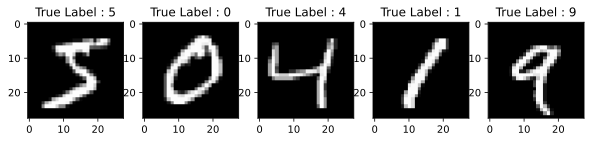

In [90]:
plt.figure(figsize=(10,6))
count= 0
for i,(image,label) in enumerate(zip(x_train[0:5],y_train[0:5])):
  plt.subplot(1,5,i+1)
  plt.imshow(image,cmap=plt.cm.gray)
  plt.title("True Label : {}".format(label,fontsize=20))
plt.show()

In [91]:
print(f'train images: {x_train.shape}')
print(f'train labels: {y_train.shape}')
print(f' test images: {x_test.shape}')
print(f' test labels: {y_test.shape}')

train images: (60000, 28, 28)
train labels: (60000,)
 test images: (10000, 28, 28)
 test labels: (10000,)


In [92]:
s = x_train[1][:][:]
print(s.shape)

(28, 28)


### **Preprocessing**

In [93]:
# flatten images to 1-D vector of 784 features (28*28)

x_train = x_train.reshape(60000 , num_features)
x_test = x_test.reshape(10000, num_features)

''' 
  another way
  x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
'''
# normalize images value from [0, 255] to [0.0, 1.0]
x_train, x_test = x_train / 255., x_test / 255.

In [94]:
print(x_train.shape)

(60000, 784)


In [95]:
# Vector containing 784 elements
print(x_train[1].shape)

(784,)


In [96]:
# After normalization
print("Min Value:{}".format(x_train[1].min()))
print("Max Value:{}".format(x_train[1].max()))

Min Value:0.0
Max Value:1.0


### **One hot encoding**

In [97]:
y_train[:4]

array([5, 0, 4, 1], dtype=uint8)

In [98]:
with tf.compat.v1.Session() as sess:
  y_train = sess.run(tf.one_hot(y_train,10))
  y_test = sess.run(tf.one_hot(y_test,10))

In [99]:
y_train[:4]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### **Hyper parameters**

In [100]:
# hyper parameters
learning_rate = 0.01
epochs = 20
batch_size = 100
batches = int(x_train.shape[0] / batch_size)


lets see how to determine the shape of W and B

$\mathbf{Y}=\sigma(\mathbf{X}\cdot\mathbf{W} + \mathbf{B})$

<img src="https://render.githubusercontent.com/render/math?math=%5Cbegin%7Bpmatrix%7D%0A%20%20%20%20y_1%20%5C%5C%20y_2%20%5C%5C%20%5Cvdots%20%5C%5C%20y_%7B10%7D%0A%5Cend%7Bpmatrix%7D%3D%5Csigma%5Cleft%5B%0A%5Cbegin%7Bpmatrix%7D%0A%20%20%20%20x_1%20%26amp%3B%20x_2%20%26amp%3B%20%5Cdots%20%26amp%3B%20x_%7B784%7D%0A%5Cend%7Bpmatrix%7D%0A%5Cbegin%7Bpmatrix%7D%0A%20%20%20%20w_%7B1%2C%201%7D%20%26amp%3B%20w_%7B1%2C%202%7D%20%20%26amp%3B%20%5Cdots%20%20%26amp%3B%20w_%7B1%2C%2010%7D%20%5C%5C%0A%20%20%20%20w_%7B2%2C%201%7D%20%26amp%3B%20w_%7B2%2C%202%7D%20%20%26amp%3B%20%5Cdots%20%20%26amp%3B%20w_%7B2%2C%2010%7D%20%5C%5C%0A%20%20%20%20%5Cvdots%20%26amp%3B%20%20%5Cvdots%20%26amp%3B%20%5Cddots%20%26amp%3B%20%5Cvdots%20%5C%5C%0A%20%20%20%20w_%7B784%2C%201%7D%20%26amp%3B%20w_%7B784%2C%202%7D%20%20%26amp%3B%20%5Cdots%20%20%26amp%3B%20w_%7B784%2C%2010%7D%0A%5Cend%7Bpmatrix%7D%20%2B%0A%5Cbegin%7Bpmatrix%7D%0A%20%20%20%20b_1%20%5C%5C%20b_2%20%5C%5C%20%5Cvdots%20%5C%5C%20b_%7B10%7D%0A%5Cend%7Bpmatrix%7D%0A%5Cright%5D&mode=inline"/>

Weights shape: 784, 10
Bias shape: 10

In [101]:
'''
  y = softmax(x*w + b)
  
  x shape = [None,784] flattend / normalized image
  w shape  = [784,10] the 28*28 image features, and total number of classes.
  b shape = vector containing element [10]
  y = one hot label vector [10]
'''
# inputs
# X is our "flattened / normalized" images
# Y is our "one hot" labels
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

# weights and bias
# weights convert X to same shape as Y
# bias is the same shape as Y

W = tf.Variable(0.1 * np.random.randn(784, 10).astype(np.float32))
B = tf.Variable(0.1 * np.random.randn(10).astype(np.float32))

In [102]:
# y = softmax(x*w + b)
pred = tf.nn.softmax(tf.add(tf.matmul(X, W), B))

# Summation of -Y(true label)*log(prediction_label)      
# predicted label would be probability of getting perticular output (0-9)
# if input image pass is = 1 
# output label = [0,1,0,0,0,0,0,0,0,0]
# predicted label = [0.01,0.98,0.002,0.0004,0.001,0.0007,0.005,0.002,0.03.0.05]

cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(pred), axis=1))

# Optimizer as gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

### **Explanation of cost function**

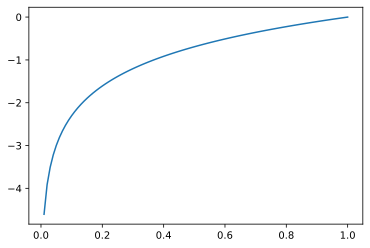

In [51]:
# log(0) is undefine 
x = np.linspace(1/100 , 1, 100)
plt.plot(x,np.log(x))
plt.show()

In [52]:
# Pred
a = np.log([[0.04,0.13,0.96,0.12],
            [0.01,0.93,0.06,0.07]])

# actual label (one hot)
b = np.array([[0,0,1,0],
              [1,0,0,0]])

'''
Here we can see "pred" makes first output is right , but in second output we can see
true label is "0"  but it makes probabiltity of "1" as high
'''
print(a*b)

[[-0.         -0.         -0.04082199 -0.        ]
 [-4.60517019 -0.         -0.         -0.        ]]


In [53]:
print(-(a*b))

[[0.         0.         0.04082199 0.        ]
 [4.60517019 0.         0.         0.        ]]


In [55]:
# axis=1 corresponds to row
r_sum = np.sum(-(a*b),axis=1) 
print(r_sum)

[0.04082199 4.60517019]


In [56]:
# Cost function will give output in the form of single scalar 
# that's reason we are using "mean"
print(np.mean(r_sum))

2.322996090254173


#### **Tensorflow Session**

In [104]:
init = tf.global_variables_initializer()

epoch: 0 cost=0.3041
epoch: 2 cost=0.5128
epoch: 4 cost=0.4544
epoch: 6 cost=0.4257
epoch: 8 cost=0.4656
epoch:10 cost=0.2093
epoch:12 cost=0.5782
epoch:14 cost=0.4302
epoch:16 cost=0.3655
epoch:18 cost=0.2473
Accuracy: 89.93%


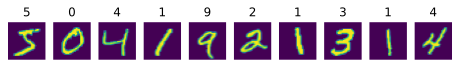

In [105]:


with tf.Session() as sesh:
    sesh.run(init)
    
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizer, feed_dict={X: x, Y:y})
            c = sesh.run(cost, feed_dict={X:x, Y:y})
        
        if not epoch % 2:
            print(f'epoch:{epoch:2d} cost={c:.4f}')
            
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    acc = accuracy.eval({X: x_test, Y: y_test})
    print(f'Accuracy: {acc * 100:.2f}%')
    
    fig, axes = plt.subplots(1, 10, figsize=(8, 4))
    for img, ax in zip(x_train[:10], axes):
        guess = np.argmax(sesh.run(pred, feed_dict={X: [img]}))
        ax.set_title(guess)
        ax.imshow(img.reshape((28, 28)))
        ax.axis('off')



**Reference**:

* [Logistic Regression with MNIST](https://www.youtube.com/watch?v=0OVldHsRxTs)
